## Traffic Simulation
#### Eynat Grof

In [5]:
import scipy
import random
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pylab
%matplotlib inline

In [6]:

class TrafficSimulation:

    def __init__ (self, length = 100, density = 0.3, maxVelocity = 5,
        probSlowDown = 0.2, num_lanes = 1, probChangeLane = 0.7):
        '''
        Initializing model parameters with default values. 
        
        Inputs:
            length (int): length of the road, number of cells.

            density (float): between 0 to 1, indicating the amount of cars on 
                the road.

            maxVelocity (int): maximum velocity of cars. 

            ProbSlowDown (float): between 0 to 1, probability of a car slowing
                down randomly.
                
            num_lanes (int):  number of lanes in the road.
            
            probChangeLane (float): probability a car will change lanes, after all other conditions are checked. 
        '''
        
        self.length = length
        self.density = density
        self.maxVelocity = maxVelocity
        self.probSlowDown = probSlowDown
        self.num_lanes = num_lanes
        self.probChangeLane = probChangeLane
        
     
    def initialize(self):
        '''
        Set up a random initial state where the fraction of cars on the road equals the
        density parameter.
        '''
        
        # create SciPy arrays to represent the road: current state
        self.current_state = -scipy.ones((self.num_lanes, self.length), dtype = int)
        
        # pick random indices on the road and put cars there with cars in varying speeds
        random_indices = scipy.random.choice(self.length,                            
            size = int(round((self.length * self.density))), 
            replace = False)
        for lane in xrange(0, self.num_lanes):
            self.current_state[lane, random_indices] = scipy.random.randint(0, self.maxVelocity+1, size = len(random_indices))
            
            
        self.step = 0
        self.flow = 0.  
        
        
        
    def change_lane(self):
        '''
        Change lane if traffic allows for it.
        Works for two lanes, not more.
        '''
        for lane in range(0, self.num_lanes):
            for i in range(0, self.length):
                if self.current_state[lane, i] != -1:
                    
                    distance = 1
                    ahead_lane = 1
                    behind_lane = 1
                    
                    if lane == 0:
                        var = 1
                    elif lane == 1:
                        var = -1
                        
                    # how much distance in ahead in current lane?
                    while self.current_state[lane, (i + distance) % self.length] == -1:
                        distance += 1
                    
                    # how much distance ahead in the other lane?
                    while self.current_state[lane + var, (i + ahead_lane)%self.length] == -1:
                        ahead_lane += 1
                        if ahead_lane > self.length:
                            break
                    
                    # how much distance behind in the other lane?
                    while self.current_state[lane + var, (i - behind_lane) % self.length] == -1:
                        behind_lane +=1
                        if behind_lane > self.length:
                            break
                                                
                    # check all conditions for switching lanes:
                    if distance < ahead_lane:  # if enough distance ahead
                        if self.current_state[lane + var, i] == -1:  # if i position in the other lane is free
                            if ahead_lane > self.current_state[lane+var, i] + 1:  # space ahead other lane
                                if behind_lane > self.maxVelocity:  # is there anyone behind in the other lane
                                    if np.random.random() < self.probChangeLane:  # prob of changing lane
                                        self.current_state[lane + var, i] = self.current_state[lane, i]
                                        self.current_state[lane+ var, i] = -1

    def calculate(self):
        '''
        Calculates CA velocities and update positions at t + 1, according to
        the follwoing rules:
        '''
        
        ### UPDATE SPEEDS: only change the velocity value of each car 
        
        if self.num_lanes >1:
            self.change_lane()

        for lane in xrange(0, self.num_lanes):
            for i in xrange(0, self.length):
                if self.current_state[lane, i] != -1:
                    distance = 1  # empty cells ahead
                    while self.current_state[lane, (i + distance) % self.length] == -1:
                        distance +=1

                    # accelerate: if car velocity < maximum velocity
                    # and distance > velocity + 1, advance speed
                    if distance > self.current_state[lane, i] + 1 and self.current_state[lane, i] < self.maxVelocity:
                        self.current_state[lane, i] = self.current_state[lane, i]+1

                    # slow: if distance <= velocity, slow down 
                    if distance <= self.current_state[lane, i]:
                        self.current_state[lane, i] = distance-1

                    # random slow: reduce speed with probability probSlowDown
                    if self.current_state[lane, i] > 0 and np.random.random() < self.probSlowDown:
                        self.current_state[lane, i] = self.current_state[lane, i]-1
       
    
        ### UPDATE POSITIONS: move each car based on updated velocity value
        
        next_state = -scipy.ones((self.num_lanes, self.length), dtype = int)
        for lane in xrange(0, self.num_lanes):
            for i in xrange(0, self.length):
                spaces = int(self.current_state[lane, i])
                if self.current_state[lane, i] != -1:
                    next_state[lane, (i + spaces) % self.length] = self.current_state[lane, i]
            self.current_state[lane] = next_state[lane]
        
        ### updating flow and time step values
        self.step += 1
        for lane in xrange(0, self.num_lanes):
            for i in xrange(0, self.maxVelocity):
                if self.current_state[lane, i] > i:
                    self.flow += 1

    def draw(self):
        for lane in range(self.num_lanes):
            print(''.join('.' if x == -1 else str(x) for x in self.current_state[lane]))
            
        if self.num_lanes > 1:
            print "\n"
            



## Running and visualizing the model

In [3]:
sim = TrafficSimulation(density = 0.5 , length = 50, num_lanes = 1)

sim.initialize()
sim.draw()
for i in range(30):
    sim.calculate()
    sim.draw()
print 'Car Density:', sim.density
print 'Traffic flow rate:', sim.flow/sim.step

01.32.5.2.5.21...10..4..5.04.0...552.4...12.1.20..
0.10.1.1.1.10..2.00....2.10.1.1..00.1...30.1.100..
0.00..1.1.10.1..10.1....10.1.1..20.1..2.0.1.100.1.
.10.1..1.10.1..200...2..0.1.1..20.1..2.1.1.100.1.1
100...2.100...2000....1..1.1..20.1.1.0.0..100.1.1.
00.1...100.1..000.1.....2.1..20.1.1.1.1.1.000..1.1
0.1..2.00.1.1.000...2...0...20.1.10..1.10.00.1.0.0
.1.1..100..1.1000......3.1..0.1.10.1..100.00.0..10
1.1..200.1..1000.1.....0...2.1.10.1..200.10.1.1.0.
0..1.00.1..2000.1..2....1..0..10.1..200.10.1.1.1.1
.1..10.1..2000.1..2..2....2.1.0.1..200.10.1.1.1.10
1..20.1.1.000.1..2..2...3.0..10...200.10.10..1.10.
..20.10..1000...2..2..2..1.1.0.1..00.10.10.1..100.
..0.100..000.1....2.1...20..1.1..20.10.10.1..200.1
1..100.1.00.1..2...1..2.0.1..1.1.0.10.10.1..200.1.
..200.1.10.1..2...3..2.1.1..20..1.10.100..1.00.10.
..00.1.10.1..2...3..2.1.1..20.1..10.100.1..10.10.1
.20.1.10.1..2...3..2.1.1..200..1.00.000..1.0.10.1.
20.10.0.1..2...3..2.1.1.1.000...100.00.1..1.10.1..
0.10.1.1..2..2...20..1.1.100.1.

## Plots

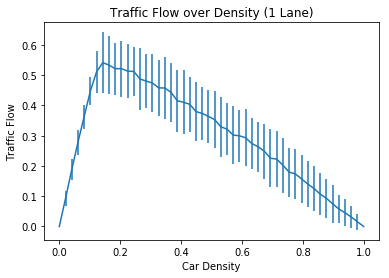

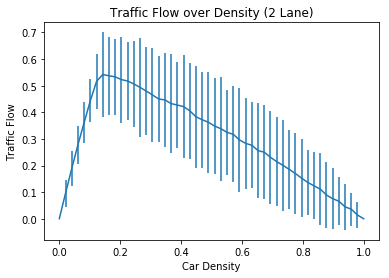

In [4]:
def visualizations(densities, number_lanes):
    '''
    Visualize the output of the model as the relationship between density and 
    average flow rate. 
    '''
    mean_flows = []
    std_flows = []

    for dens in densities:
        flows = []
        for j in range(100):  
            sim = TrafficSimulation(density=dens, num_lanes = number_lanes)
            sim.initialize()
            for i in range(50):  
                    sim.calculate()
            avg_flow = sim.flow / float(sim.step)
            flows.append(avg_flow)
        mean_flows.append(np.mean(flows) / float(number_lanes))
        std_flows.append(np.std(flows))
    
    plt.errorbar(scipy.linspace(0,1,50), mean_flows, xerr=0, yerr= 1.96*np.array(std_flows))
    plt.title('Traffic Flow over Density ({} Lane)'.format(number_lanes))
    plt.ylabel('Traffic Flow')
    plt.xlabel('Car Density')
    plt.show()
    

visualizations(np.linspace(0, 1, 50), 1)
visualizations(np.linspace(0, 1, 50), 2)